In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import math
import numpy as np

In [2]:
df = pd.read_csv("../data/processed/faturamento_vendas_diaria.csv")
print(df.shape)
df.head()

(1783, 2)


,Unnamed: 0,VAL_CUSTO_CONTABIL
0,2015-02-02,0.0
1,2015-02-03,0.0
2,2015-02-04,0.0
3,2015-02-05,0.0
4,2015-02-06,0.0


In [3]:
df = df.rename(columns={"Unnamed: 0": "data","VAL_CUSTO_CONTABIL":"faturamento"})
df.tail()

,data,faturamento
1778,2019-12-16,0.00
1779,2019-12-17,0.00
1780,2019-12-18,0.00
1781,2019-12-19,0.00
1782,2019-12-20,44375.13


In [4]:
df = df.loc[df.data < '2019-05-01']
df.index = df.data

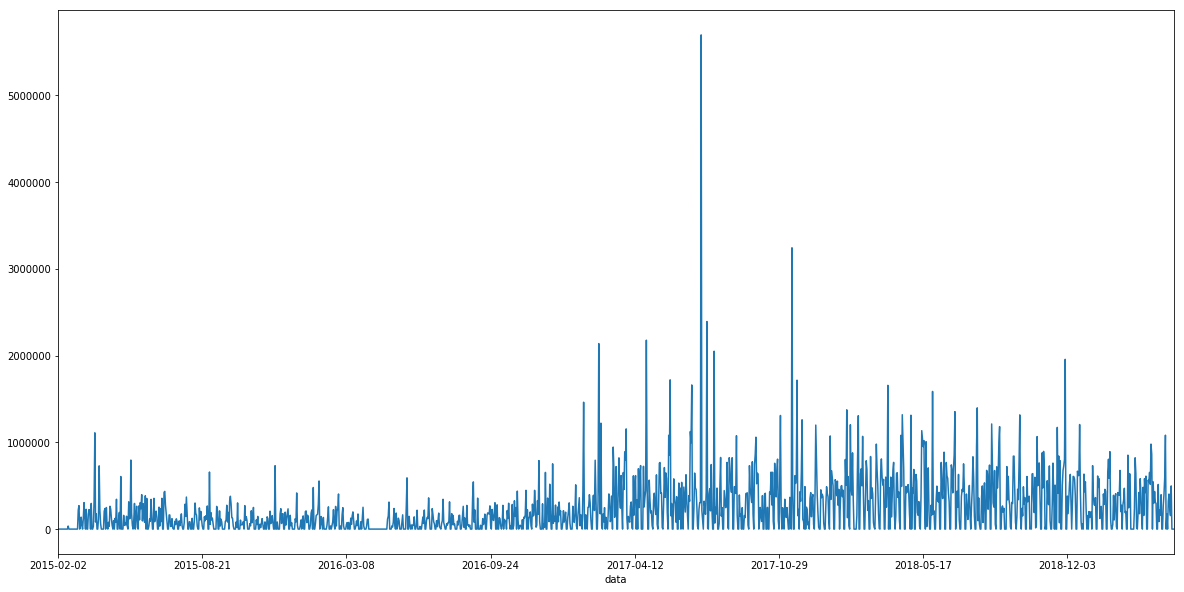

In [5]:
df.faturamento.plot.line(figsize=(20,10))

### Feature engineering

In [6]:
df.data = pd.to_datetime(df.data)

In [7]:
df['dayofmonth'] = df.data.dt.day
df['dayofweek'] = df.data.dt.dayofweek
df['month'] = df.data.dt.month
df['year'] = df.data.dt.year
df.head()

,data,faturamento,dayofmonth,dayofweek,month,year
data,,,,,,
2015-02-02,2015-02-02,0.0,2,0,2,2015
2015-02-03,2015-02-03,0.0,3,1,2,2015
2015-02-04,2015-02-04,0.0,4,2,2,2015
2015-02-05,2015-02-05,0.0,5,3,2,2015
2015-02-06,2015-02-06,0.0,6,4,2,2015


In [8]:
df['small_MA'] = df.faturamento.rolling(window=20).mean()
df['big_MA'] = df.faturamento.rolling(window=30).mean()

In [9]:
# retira os primeiros registros após o shift, pois esses possuem NaN em suas colunas
df.dropna(inplace=True)
df.head()

,data,faturamento,dayofmonth,dayofweek,month,year,small_MA,big_MA
data,,,,,,,,
2015-03-03,2015-03-03,270500.47,3,1,3,2015,26277.7505,17518.500333
2015-03-04,2015-03-04,0.00,4,2,3,2015,26277.7505,17518.500333
2015-03-05,2015-03-05,32725.16,5,3,3,2015,27914.0085,18609.339000
2015-03-06,2015-03-06,137780.52,6,4,3,2015,34803.0345,23202.023000
2015-03-07,2015-03-07,48832.26,7,5,3,2015,37244.6475,24829.765000


In [10]:
reg = RandomForestRegressor(max_depth = 5, n_estimators = 100)

### Split do dataset

In [11]:
X = df.drop(['data','faturamento'],axis=1)
y = df[['faturamento']]

In [12]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=9)
#print("X_train shape:",X_train.shape,"X_test shape:", X_test.shape)

### Split manual

In [13]:
test_size = int(len(X) * 0.2)
train_size = len(X) - test_size
X_train = X[:train_size]
X_test = X[train_size:]
len(X_train),len(X_test), len(X_train) + len(X_test)

(1216, 304, 1520)

In [14]:
y_train = y[:train_size]
y_test = y[train_size:]
len(y_train),len(y_test), len(y_train) + len(y_test)

(1216, 304, 1520)

In [15]:
reg.fit(X_train, y_train)

/home/user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
trainPredict = reg.predict(X_train)
testPredict = reg.predict(X_test)

In [17]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, testPredict))

# RMSE
print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(y_test, testPredict)))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(y_test, testPredict))

Mean squared error: 49962940365.63
Root Mean squared error: 223523.91
R2 score: 0.51


In [18]:
total_predicts = np.concatenate((trainPredict,testPredict))
for i in range(len(trainPredict)):
    testPredict = np.insert(testPredict, 0, [np.NaN])

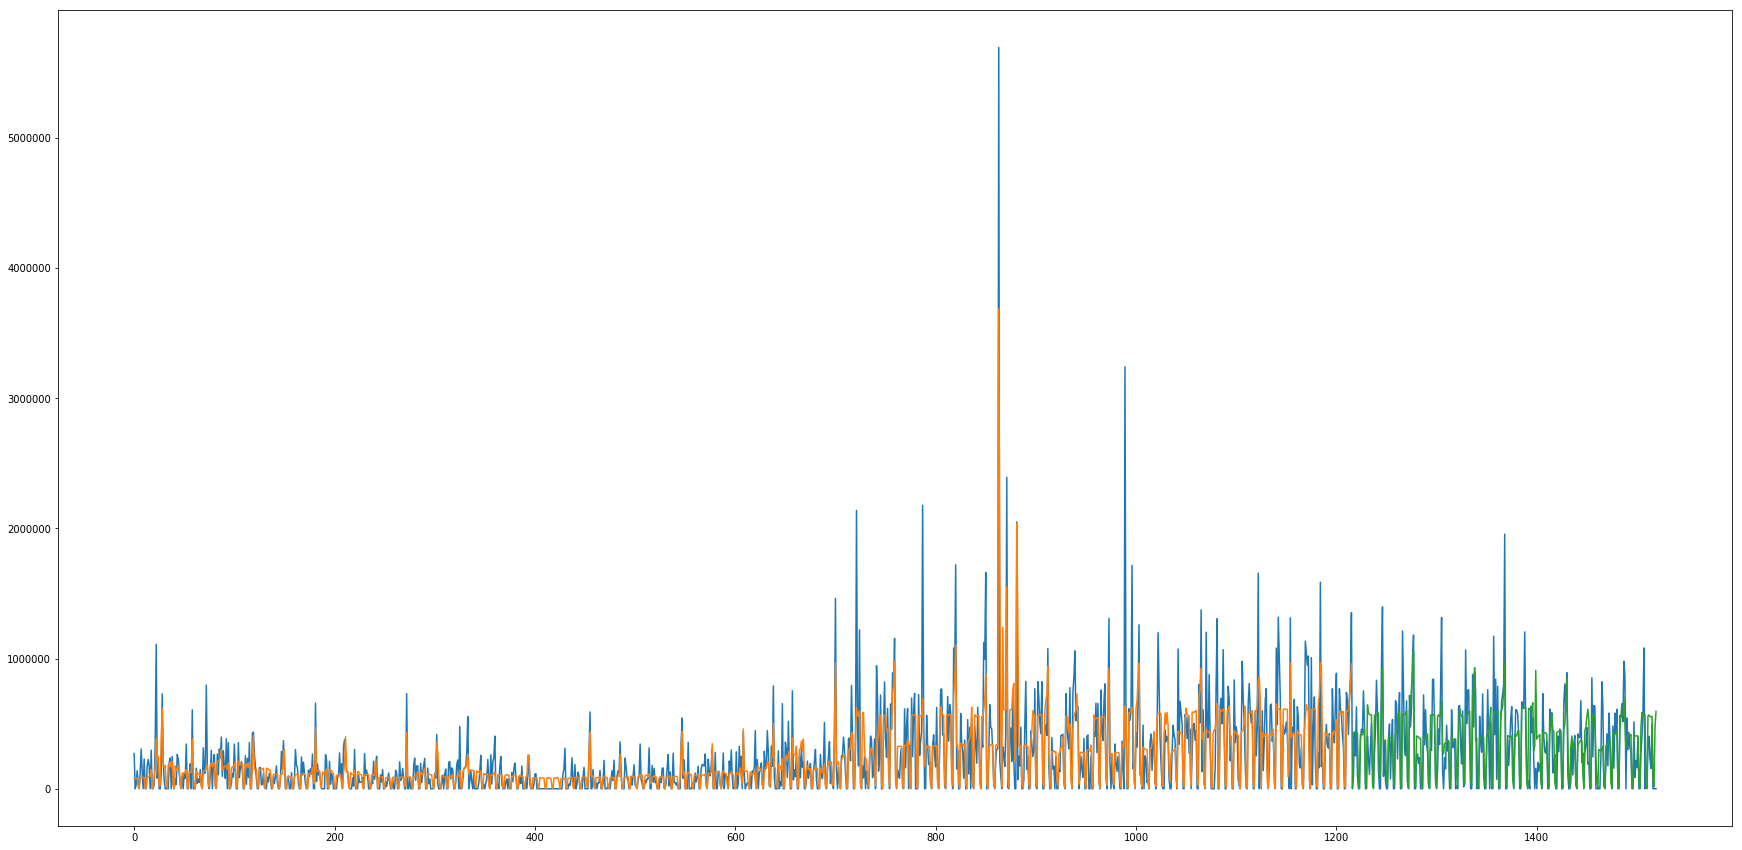

In [23]:
# plot baseline and predictions
plt.plot(df.faturamento.values)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.rcParams['figure.figsize'] = [30, 15]
plt.show()

In [20]:
len(total_predicts)

1520

In [21]:
df['qtd_faturamento_previsto'] = total_predicts

In [24]:
df.to_csv("../data/processed/forecast_faturamento_carros.csv")